Part 3: Implementing & Improving AlexNet

In [ ]:
# !ls drive/MyDrive

In [9]:
!unrar x dataset_a2.rar

Streaming output truncated to the last 5000 lines.
Extracting  dataset_a2/vehicles/55.jpg                                    83%  OK 
Extracting  dataset_a2/vehicles/550.jpg                                   83%  OK 
Extracting  dataset_a2/vehicles/5500.jpg                                  83%  OK 
Extracting  dataset_a2/vehicles/5501.jpg                                  83%  OK 
Extracting  dataset_a2/vehicles/5502.jpg                                  83%  OK 
Extracting  dataset_a2/vehicles/5503.jpg                                  83%  OK 
Extracting  dataset_a2/vehicles/5504.jpg                                  83%  OK 
Extracting  dataset_a2/vehicles/5505.jpg                                  83%  OK 
Extracting  dataset_a2/vehicles/5506.jpg                                  83%  OK 
Extracting  dataset_a2/vehicles/5507.jpg                                  83%  OK 
Extracting  dataset_a2/vehicl

In [ ]:
# !cp -r /content/drive/MyDrive/dataset_a2 .

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import glob
import torch.nn as nn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
from torchvision.transforms import transforms
import pathlib

In [7]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [23]:
import six
transformer=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
path=r'dataset_a2'
dataset=DataLoader(torchvision.datasets.ImageFolder(path,transform=transformer),batch_size=256,shuffle=True)
train_size=int(0.8*len(dataset))
test_size=len(dataset)-train_size
train_dataset,test_dataset=torch.utils.data.random_split(dataset,[train_size, test_size])
train_loader=DataLoader(train_dataset,batch_size=256,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=256,shuffle=False)


PCA scatter plot for dataset

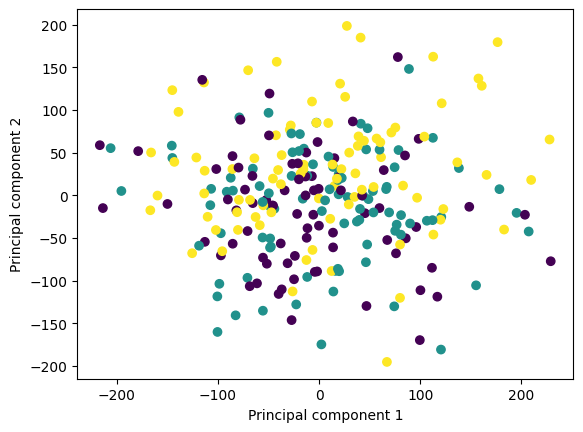

In [ ]:
from sklearn.decomposition import PCA
data,tar=next(iter(train_dataset.dataset))
batch_size=data.shape[0]
data=data.view(batch_size,-1)
pca=PCA(n_components=2)
x=pca.fit_transform(data.numpy())
plt.scatter(x[:,0],x[:,1],c=tar)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()

Dataset Statistics

In [26]:
train_mean=0
train_std=0
test_mean=0
test_std=0
nb_samples_train=0
nb_samples_test=0
for data, _ in train_dataset.dataset:
    batch_samples=data.size(0)
    data=data.view(batch_samples, data.size(1), -1)
    train_mean=train_mean+data.mean(2).sum(0)
    train_std=train_std+data.std(2).sum(0)
    nb_samples_train=nb_samples_train+batch_samples
train_mean=train_mean/nb_samples_train
train_std=train_std/nb_samples_train
for data, _ in test_dataset.dataset:
    batch_samples=data.size(0)
    data=data.view(batch_samples, data.size(1), -1)
    test_mean=test_mean+data.mean(2).sum(0)
    test_std=test_std+data.std(2).sum(0)
    nb_samples_test=nb_samples_test+batch_samples

test_mean=test_mean/nb_samples_test
test_std=test_std/nb_samples_test

print('Train Mean:',train_mean)
print('Train Std:',train_std)
print('Test Mean:',test_mean)
print('Test Std:',test_std)

Train Mean: tensor([ 0.0101, -0.0992, -0.2314])
Train Std: tensor([0.4543, 0.4537, 0.4580])
Test Mean: tensor([ 0.0101, -0.0992, -0.2314])
Test Std: tensor([0.4543, 0.4537, 0.4580])


Result of data augmentation on random image from dataset

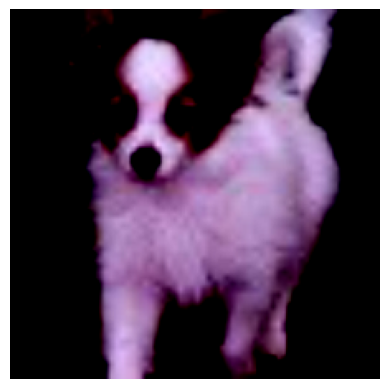

In [18]:
import matplotlib.pyplot as plt
import numpy as np
for img,label in train_dataset.dataset:
    break
idx=np.random.randint(len(img))
img=img[idx]
plt.imshow(np.transpose(img,(1, 2, 0)))
plt.axis('off')
plt.show()


Base Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self,classes_count):
        super(AlexNet,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2,device=device),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(64,192,kernel_size=5,padding=2,device=device),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(192,384,kernel_size=3,padding=1,device=device),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,kernel_size=3,padding=1,device=device),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1,device=device),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
        )
        self.avgpool=nn.AdaptiveAvgPool2d((6, 6))
        self.classifier=nn.Sequential(
            #nn.Dropout(),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,classes_count), 
        )

    def forward(self, x):
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        x=self.classifier(x)
        return x


In [ ]:
import torch.optim as optim

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)
net=AlexNet(3)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
for epoch in range(40):
    running_loss=0.0
    for i, data in enumerate(train_dataset.dataset, 0):
        input,labels=data
        input,labels=input.to(device),labels.to(device)
        optimizer.zero_grad()
        output=net(input)
        loss=criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss=running_loss+loss.item()
        if(i%50==49):
            print('EPOCH:',epoch+1,'loss:',running_loss/50)
            running_loss=0.0
pred=0
total=0
with torch.no_grad():
    for data in test_dataset.dataset:
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        outputs=net(images)
        _, predicted=torch.max(outputs.data, 1)
        total=total+labels.size(0)
        pred=pred+(predicted==labels).sum().item()
print('Accuracy on the test images:',100*pred/total)


device: cuda:0
EPOCH: 1 loss: 1.09868896484375
EPOCH: 1 loss: 1.0983688926696777
EPOCH: 2 loss: 1.098122115135193
EPOCH: 2 loss: 1.0977790260314941
EPOCH: 3 loss: 1.0975086903572082
EPOCH: 3 loss: 1.0970374822616578
EPOCH: 4 loss: 1.0962691259384156
EPOCH: 4 loss: 1.095353434085846
EPOCH: 5 loss: 1.0934499788284302
EPOCH: 5 loss: 1.0910438632965087
EPOCH: 6 loss: 1.0840639877319336
EPOCH: 6 loss: 1.0722215723991395
EPOCH: 7 loss: 1.0063911747932435
EPOCH: 7 loss: 0.8392084538936615
EPOCH: 8 loss: 0.712400553226471
EPOCH: 8 loss: 0.6961218523979187
EPOCH: 9 loss: 0.6602498745918274
EPOCH: 9 loss: 0.6318876147270203
EPOCH: 10 loss: 0.6064690488576889
EPOCH: 10 loss: 0.5950347030162811
EPOCH: 11 loss: 0.5560520833730698
EPOCH: 11 loss: 0.5438860666751861
EPOCH: 12 loss: 0.5159809917211533
EPOCH: 12 loss: 0.5120099323987961
EPOCH: 13 loss: 0.4963699209690094
EPOCH: 13 loss: 0.4718930858373642
EPOCH: 14 loss: 0.4467079800367355
EPOCH: 14 loss: 0.4338293391466141
EPOCH: 15 loss: 0.3975243085

In [ ]:
pred=0
total=0
with torch.no_grad():
    for data in train_dataset.dataset:
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        outputs=net(images)
        _, predicted=torch.max(outputs.data, 1)
        total=total+labels.size(0)
        pred=pred+(predicted==labels).sum().item()
print('Accuracy on the train images:',100*pred/total)

Accuracy on the train images: 92.11


Text(0.5, 1.0, 'Base Model comparison')

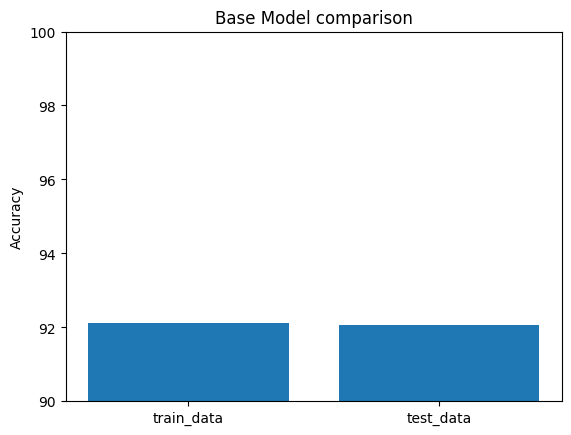

In [ ]:
import matplotlib.pyplot as plt
train_data=92.11
test_data=92.06
plt.bar(['train_data', 'test_data'], [train_data,test_data])
plt.ylim(90, 100)
plt.ylabel('Accuracy')
plt.title('Base Model comparison')


Batch Normalization

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, classes_count):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2,device=device),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64,192,kernel_size=5,padding=2,device=device),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(192,384,kernel_size=3,padding=1,device=device),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,kernel_size=3,padding=1,device=device),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1,device=device),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
        )
        self.avgpool=nn.AdaptiveAvgPool2d((6,6))
        self.classifier=nn.Sequential(
            #nn.Dropout(),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,classes_count), 
        )

    def forward(self, x):
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x, 1)
        x=self.classifier(x)
        return x


In [ ]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)
net = AlexNet(3)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#PATH = "/content/drive/MyDrive/checkpoints-ml-project/"
for epoch in range(40):
    running_loss=0.0
    for i, data in enumerate(train_dataset.dataset, 0):
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss=running_loss+loss.item()
        if(i%50==49):
            print('EPOCH:',epoch+1 ,'loss:',running_loss/50)
            running_loss=0.0
pred=0
total=0
with torch.no_grad():
    for data in test_dataset.dataset:
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        outputs=net(images)
        _, predicted=torch.max(outputs.data, 1)
        total=total+labels.size(0)
        pred=pred+(predicted==labels).sum().item()
print('Accuracy on the test images:',pred/total*100)


Device: cuda:0
EPOCH: 1 loss: 0.982308589220047
EPOCH: 1 loss: 0.6094617724418641
EPOCH: 2 loss: 0.3745163810253143
EPOCH: 2 loss: 0.3284421595931053
EPOCH: 3 loss: 0.3052026304602623
EPOCH: 3 loss: 0.2747907418012619
EPOCH: 4 loss: 0.2657390460371971
EPOCH: 4 loss: 0.24621271699666977
EPOCH: 5 loss: 0.23212990641593934
EPOCH: 5 loss: 0.21650082349777222
EPOCH: 6 loss: 0.21070010840892792
EPOCH: 6 loss: 0.2117183420062065
EPOCH: 7 loss: 0.20269002854824067
EPOCH: 7 loss: 0.20042226046323777
EPOCH: 8 loss: 0.1854407462477684
EPOCH: 8 loss: 0.19895638197660445
EPOCH: 9 loss: 0.1842550553381443
EPOCH: 9 loss: 0.1754030802845955
EPOCH: 10 loss: 0.16940141782164575
EPOCH: 10 loss: 0.16644446611404418
EPOCH: 11 loss: 0.1611039474606514
EPOCH: 11 loss: 0.1613547584414482
EPOCH: 12 loss: 0.14222887128591538
EPOCH: 12 loss: 0.15339234411716463
EPOCH: 13 loss: 0.14930739685893057
EPOCH: 13 loss: 0.15412104442715646
EPOCH: 14 loss: 0.14264967754483224
EPOCH: 14 loss: 0.1463634692132473
EPOCH: 15 

In [ ]:
pred=0
total=0
with torch.no_grad():
    for data in train_dataset.dataset:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        pred += (predicted == labels).sum().item()

print('Accuracy on the train images:',100*pred/total)


Accuracy on the train images: 98.66


Text(0.5, 1.0, 'BatchNorm Model comparison')

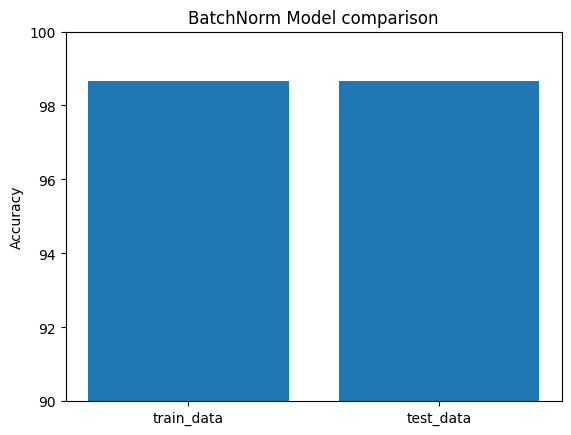

In [ ]:
import matplotlib.pyplot as plt
train_data=98.66
test_data=98.65
plt.bar(['train_data', 'test_data'], [train_data,test_data])
plt.ylim(90, 100)
plt.ylabel('Accuracy')
plt.title('BatchNorm Model comparison')


Weight Decay

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self,classes_count):
        super(AlexNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2,device=device),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(64,192,kernel_size=5,padding=2,device=device),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(192,384,kernel_size=3,padding=1,device=device),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,kernel_size=3,padding=1,device=device),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1,device=device),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
        )
        self.avgpool=nn.AdaptiveAvgPool2d((6,6))
        self.classifier=nn.Sequential(
            #nn.Dropout(),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,classes_count), 
        )

    def forward(self,x):
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        x=self.classifier(x)
        return x


In [ ]:
import torch.optim as optim

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
net=AlexNet(3)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,momentum=0.9,weight_decay=0.001)
#PATH = "/content/drive/MyDrive/checkpoints-ml-project/"
print("Training is starting here")
for epoch in range(40):
    running_loss = 0.0
    for i, data in enumerate(train_dataset.dataset, 0):
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=net(inputs)
        loss=criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss=running_loss+loss.item()
        if(i%50==49):
            print('EPOCH:',epoch+1 ,'loss:',running_loss/50)
            running_loss=0.0
pred=0
total=0
with torch.no_grad():
    for data in test_dataset.dataset:
        images,labels=data
        images,labels=images.to(device), labels.to(device)
        outputs=net(images)
        _, predicted = torch.max(outputs.data, 1)
        total=total+labels.size(0)
        pred=pred+(predicted == labels).sum().item()
print('Accuracy on the test images:',100*pred/total)


Using device: cuda:0
Training is starting here
EPOCH: 1 loss: 1.0984167623519898
EPOCH: 1 loss: 1.0981286811828612
EPOCH: 2 loss: 1.0976328325271607
EPOCH: 2 loss: 1.0973226928710937
EPOCH: 3 loss: 1.0964751553535461
EPOCH: 3 loss: 1.0955003118515014
EPOCH: 4 loss: 1.0937905406951904
EPOCH: 4 loss: 1.0909040474891663
EPOCH: 5 loss: 1.0834157013893126
EPOCH: 5 loss: 1.0678985810279846
EPOCH: 6 loss: 0.9879734659194946
EPOCH: 6 loss: 0.8145037937164307
EPOCH: 7 loss: 0.723911691904068
EPOCH: 7 loss: 0.68744389295578
EPOCH: 8 loss: 0.6615072607994079
EPOCH: 8 loss: 0.6450819671154022
EPOCH: 9 loss: 0.6297107505798339
EPOCH: 9 loss: 0.6129989290237426
EPOCH: 10 loss: 0.5955192178487778
EPOCH: 10 loss: 0.5753712975978851
EPOCH: 11 loss: 0.5625562059879303
EPOCH: 11 loss: 0.5357858687639236
EPOCH: 12 loss: 0.5324921733140946
EPOCH: 12 loss: 0.47641886711120607
EPOCH: 13 loss: 0.45715616941452025
EPOCH: 13 loss: 0.43500483453273775
EPOCH: 14 loss: 0.41141776025295257
EPOCH: 14 loss: 0.4108050

In [ ]:
pred=0
total=0
with torch.no_grad():
    for data in train_dataset.dataset:
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        outputs=net(images)
        _, predicted=torch.max(outputs.data, 1)
        total=total+labels.size(0)
        pred=pred+(predicted==labels).sum().item()
print('Accuracy on the train images:',100*pred/total)


Accuracy on the train images: 91.13666666666667


Text(0.5, 1.0, 'Weight Decay Model comparison')

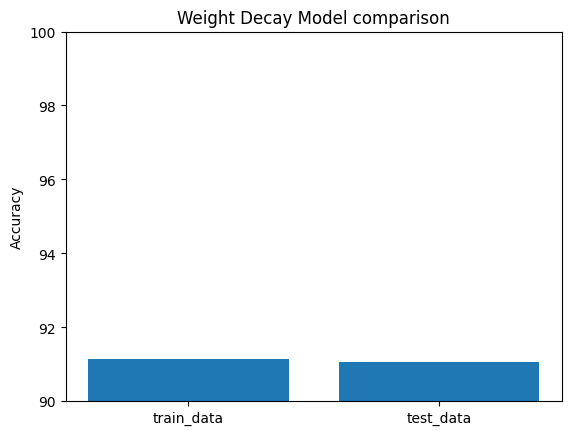

In [ ]:
import matplotlib.pyplot as plt
train_data=91.13
test_data=91.05
plt.bar(['train_data', 'test_data'], [train_data,test_data])
plt.ylim(90, 100)
plt.ylabel('Accuracy')
plt.title('Weight Decay Model comparison')


Comparison of test accuracies

Text(0.5, 1.0, 'Test accuracy comparison')

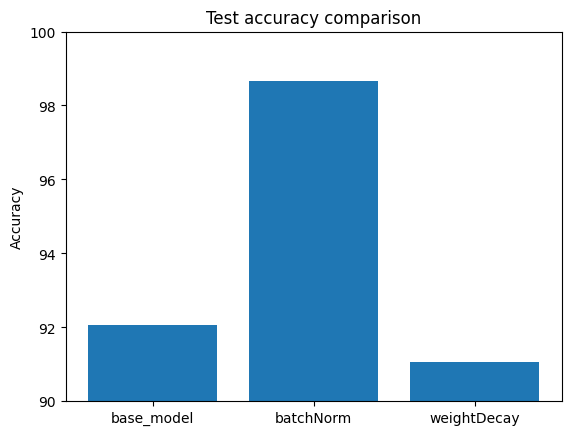

In [ ]:
import matplotlib.pyplot as plt
base_model=92.06
batchNorm=98.65
weightDecay=91.05
plt.bar(['base_model', 'batchNorm','weightDecay'], [base_model,batchNorm,weightDecay])
plt.ylim(90, 100)
plt.ylabel('Accuracy')
plt.title('Test accuracy comparison')


Train accuracy comparison

Text(0.5, 1.0, 'Train accuracy comparison')

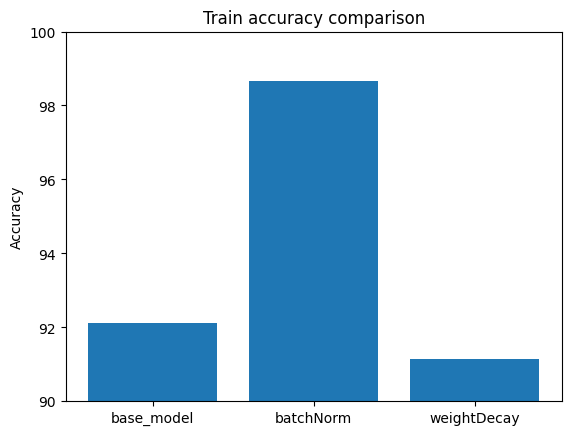

In [30]:
import matplotlib.pyplot as plt
base_model=92.11
batchNorm=98.66
weightDecay=91.13
plt.bar(['base_model', 'batchNorm','weightDecay'], [base_model,batchNorm,weightDecay])
plt.ylim(90, 100)
plt.ylabel('Accuracy')
plt.title('Train accuracy comparison')


Part 4: Optimizing CNN + Data Argumentation

In [20]:
import torch
from torchvision import datasets
root_dir='./data'
import six
transformer=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomCrop(size=224,padding=4),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
dataset=datasets.SVHN(root=root_dir,transform=transformer,download=True,)
train_size=int(0.8*len(dataset))
test_size=len(dataset)-train_size
train_dataset,test_dataset=torch.utils.data.random_split(dataset,[train_size, test_size])
train_loader=DataLoader(train_dataset,batch_size=256,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=256,shuffle=False)


Using downloaded and verified file: ./data/train_32x32.mat


In [4]:
print(len(dataset))

73257


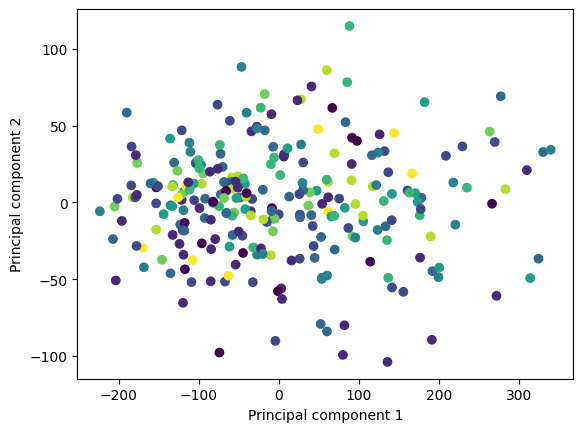

In [ ]:
from sklearn.decomposition import PCA
data,tar=next(iter(train_loader))
batch_size=data.shape[0]
data=data.view(batch_size,-1)
pca=PCA(n_components=2)
x=pca.fit_transform(data.numpy())
plt.scatter(x[:,0],x[:,1],c=tar)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()

<class 'torch.utils.data.dataset.Subset'>


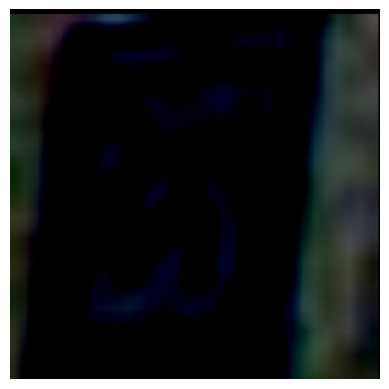

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
print(type(train_dataset))
print(train_dataset)
idx=np.random.randint(len(train_dataset))
img, label=train_dataset[idx]
plt.imshow(np.transpose(img,(1, 2, 0)))
plt.axis('off')
plt.show()

In [21]:
train_mean=0
train_std=0
test_mean=0
test_std=0
nb_samples_train=0
nb_samples_test=0
for data, _ in train_loader:
    batch_samples=data.size(0)
    data=data.view(batch_samples, data.size(1), -1)
    train_mean=train_mean+data.mean(2).sum(0)
    train_std=train_std+data.std(2).sum(0)
    nb_samples_train=nb_samples_train+batch_samples
train_mean=train_mean/nb_samples_train
train_std=train_std/nb_samples_train
for data, _ in test_loader:
    batch_samples=data.size(0)
    data=data.view(batch_samples, data.size(1), -1)
    test_mean=test_mean+data.mean(2).sum(0)
    test_std=test_std+data.std(2).sum(0)
    nb_samples_test=nb_samples_test+batch_samples

test_mean=test_mean/nb_samples_test
test_std=test_std/nb_samples_test

print('Train Mean:',train_mean)
print('Train Std:',train_std)
print('Test Mean:',test_mean)
print('Test Std:',test_std)

Train Mean: tensor([-0.1422, -0.1302, -0.0729])
Train Std: tensor([0.2656, 0.2713, 0.2451])
Test Mean: tensor([-0.1421, -0.1299, -0.0728])
Test Std: tensor([0.2662, 0.2720, 0.2455])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, classes_count):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=11, stride=4, padding=2,device=device),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64,192,kernel_size=5,padding=2,device=device),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(192,384, kernel_size=3,padding=1,device=device),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256, kernel_size=3,padding=1,device=device),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256, kernel_size=3,padding=1,device=device),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
        )
        self.avgpool=nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,classes_count), 
        )

    def forward(self, x):
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        x=self.classifier(x)
        return x


In [ ]:
import torch.optim as optim

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
net=AlexNet(10)
net.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
print("Training started...")
for epoch in range(50):
    running_loss=0.0
    for i,data in enumerate(train_loader, 0):
        input,labels=data
        input,labels=inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output=net(input)
        loss=criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss=running_loss+loss.item()
        if(i%50==49):
            print('Epoch:',epoch+1,'Loss:', running_loss/50)
            running_loss=0.0
print("Training finished!")
pred=0
total=0
with torch.no_grad():
    for data in test_loader:
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        outputs=net(images)
        _, predicted=torch.max(outputs.data, 1)
        total=total+labels.size(0)
        pred=pred+(predicted==labels).sum().item()
print('Accuracy on the test images:',round(100*pred/total))


Using device: cuda:0
Training started...
Epoch: 1 Loss: 2.2988927936553956
Epoch: 1 Loss: 2.2904268217086794
Epoch: 1 Loss: 2.2818626260757444
Epoch: 1 Loss: 2.2746373128890993
Epoch: 2 Loss: 2.2649311017990112
Epoch: 2 Loss: 2.2610460472106935
Epoch: 2 Loss: 2.2575932264328005
Epoch: 2 Loss: 2.2531614398956297
Epoch: 3 Loss: 2.250289239883423
Epoch: 3 Loss: 2.2485457611083985
Epoch: 3 Loss: 2.2412068843841553
Epoch: 3 Loss: 2.242124056816101
Epoch: 4 Loss: 2.242433958053589
Epoch: 4 Loss: 2.2380372524261474
Epoch: 4 Loss: 2.2404981374740602
Epoch: 4 Loss: 2.236361846923828
Epoch: 5 Loss: 2.2386339473724366
Epoch: 5 Loss: 2.2358893871307375
Epoch: 5 Loss: 2.237993083000183
Epoch: 5 Loss: 2.2381884479522705
Epoch: 6 Loss: 2.2397027730941774
Epoch: 6 Loss: 2.2383772706985474
Epoch: 6 Loss: 2.237127437591553
Epoch: 6 Loss: 2.234849362373352
Epoch: 7 Loss: 2.237821249961853
Epoch: 7 Loss: 2.237572793960571
Epoch: 7 Loss: 2.240640630722046
Epoch: 7 Loss: 2.2330096435546873
Epoch: 8 Loss: 2.

In [ ]:
pred=0
total=0
with torch.no_grad():
    for data in train_loader:
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        outputs=net(images)
        _, predicted=torch.max(outputs.data, 1)
        total=total+labels.size(0)
        pred=pred+(predicted == labels).sum().item()
print('Accuracy on the train images:',round(100*pred/total))


Accuracy on the train images: 81 %


Text(0.5, 1.0, 'Comparison')

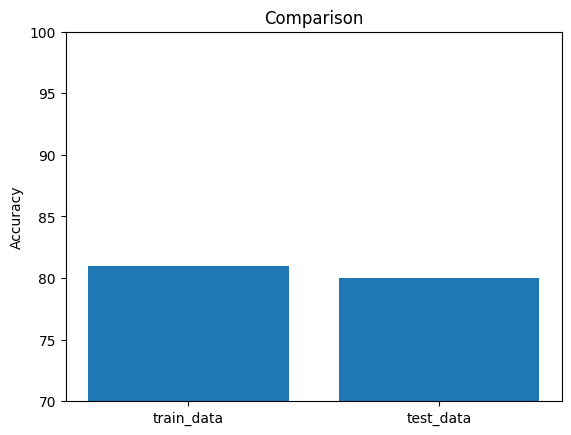

In [ ]:
import matplotlib.pyplot as plt
train_data=81
test_data=80
plt.bar(['train_data', 'test_data'], [train_data,test_data])
plt.ylim(70, 100)
plt.ylabel('Accuracy')
plt.title('Comparison')
